In [1]:
!pip install matplotlib --upgrade

url = 'https://anaconda.org/conda-forge/libta-lib/0.4.0/download/linux-64/libta-lib-0.4.0-h516909a_0.tar.bz2'
!curl -L $url | tar xj -C /usr/lib/x86_64-linux-gnu/ lib --strip-components=1
url = 'https://anaconda.org/conda-forge/ta-lib/0.4.19/download/linux-64/ta-lib-0.4.19-py37ha21ca33_2.tar.bz2'
!curl -L $url | tar xj -C /usr/local/lib/python3.7/dist-packages/ lib/python3.7/site-packages/talib --strip-components=3

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 11.2 MB 5.1 MB/s 
     |████████████████████████████████| 957 kB 34.0 MB/s 
  Attempting uninstall: matplotlib
    Found existing installation: matplotlib 3.2.2
    Uninstalling matplotlib-3.2.2:
      Successfully uninstalled matplotlib-3.2.2


  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100  3939    0  3939    0     0  14017      0 --:--:-- --:--:-- --:--:-- 13968
100  503k  100  503k    0     0   730k      0 --:--:-- --:--:-- --:--:--  730k
  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100  3947    0  3947    0     0  23355      0 --:--:-- --:--:-- --:--:-- 23355
100  406k  100  406k    0     0   783k      0 --:--:-- --:--:-- --:--:--  783k


In [1]:
import matplotlib.pyplot as plt, numpy as np, seaborn as sns, pandas as pd, talib, statsmodels.api as sm, tensorflow as tf, keras.losses
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import ParameterGrid
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.neighbors import KNeighborsRegressor
from sklearn.preprocessing import scale
from sklearn.metrics import r2_score
from keras.models import Sequential
from keras.layers import Dense, Dropout

## ***Explore the data with some EDA***

First, let's explore the data. Any time we begin a machine learning (ML) project, we need to first do some exploratory data analysis (EDA) to familiarize ourselves with the data. This includes things like:

* raw data plots
* histograms
* and more…

I typically begin with raw data plots and histograms. This allows us to understand our data's distributions. If it's a normal distribution, we can use things like parametric statistics.

There are two stocks loaded for you into pandas DataFrames: `lng_df` and `spy_df` (LNG and SPY). Take a look at them with `.head()`. We'll use the closing prices and eventually volume as inputs to ML algorithms.

Note: We'll call **`plt.clf()`** each time we want to make a new plot, or **`f = plt.figure()`**.

* Print out the first 5 lines of the two DataFrame (`lng_df` and `spy_df`) and examine their contents.

* Use the `pandas` library to plot raw time series data for `'SPY'` and '`LNG'` with the adjusted close price (`'Adj_Close'`) -- set **`legend=True`** in `.plot()`.

* Use `plt.show()` to show the raw time series plot (`matplotlib.pyplot` has been imported as `plt`).

* Use `pandas` and `matplotlib` to make a histogram of the adjusted close 1-day percent difference (use **`.pct_change()`**) for SPY and LNG.


            Adj_Close  Adj_Volume
Date                             
2016-04-15      37.13   4294000.0
2016-04-18      36.90   3446000.0
2016-04-19      37.12   3748000.0
2016-04-20      37.77   2470000.0
2016-04-21      37.21   2044000.0
            Adj_Close  Adj_Volume
Date                             
2016-04-15    198.867  75760000.0
2016-04-18    200.264  75280000.0
2016-04-19    200.896  88320000.0
2016-04-20    201.087  81100000.0
2016-04-21    200.006  85700000.0


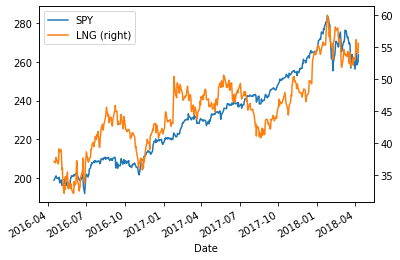

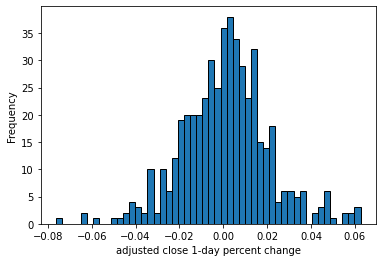

In [3]:
lng_df, spy_df = pd.read_csv('LNG_DC.csv', index_col='Date', parse_dates=True), pd.read_csv('SPY_DC.csv', index_col='Date', parse_dates=True)

print(lng_df.head())  # examine the DataFrames
print(spy_df.head())  # examine the SPY DataFrame

# Plot the Adj_Close columns for SPY and LNG
spy_df['Adj_Close'].plot(label='SPY', legend=True)
lng_df['Adj_Close'].plot(label='LNG', legend=True, secondary_y=True)
plt.show()  # show the plot
plt.clf()  # clear the plot space

# Histogram of the daily price change percent of Adj_Close for LNG
lng_df['Adj_Close'].pct_change().plot.hist(bins=50, edgecolor='black')
plt.xlabel('adjusted close 1-day percent change')
plt.show()


## ***Correlations***

Correlations are nice to check out before building machine learning models, because we can see which features correlate to the target most strongly. Pearson's correlation coefficient is often used, which only detects linear relationships. It's commonly assumed our data is normally distributed, which we can "eyeball" from histograms. Highly correlated variables have a Pearson correlation coefficient near 1 (positively correlated) or -1 (negatively correlated). A value near 0 means the two variables are not linearly correlated.

If we use the same time periods for previous price changes and future price changes, we can see if the stock price is <ins>***mean-reverting***</ins> (bounces around) or <ins>***trend-following***</ins> (goes up if it has been going up recently).

Using the `lng_df` DataFrame and its `Adj_Close`:

* Create the 5-day future price (as `5d_future_close`) with `pandas`' **`.shift(-5)`**.

* Use **`.pct_change(5)`** on `5d_future_close` and `Adj_Close` to create the future 5-day % price change (`5d_close_future_pct`), and the current 5-day % price change (`5d_close_pct`).

* Examine correlations between the two 5-day percent price change columns with **`.corr()`** on `lng_df`.

* Using **`plt.scatter()`**, make a scatterplot of `5d_close_pct` vs `5d_close_future_pct`.

                     5d_close_pct  5d_close_future_pct
5d_close_pct             1.000000            -0.164861
5d_close_future_pct     -0.164861             1.000000


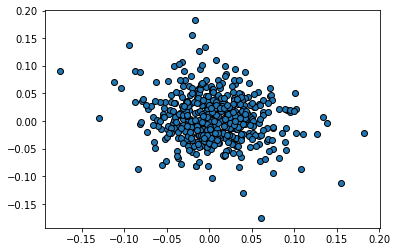

In [4]:
# Create 5-day % changes of Adj_Close for the current day, and 5 days in the future
lng_df['5d_future_close'] = lng_df['Adj_Close'].shift(-5)
lng_df['5d_close_future_pct'] = lng_df['5d_future_close'].pct_change(5)
lng_df['5d_close_pct'] = lng_df['Adj_Close'].pct_change(5)

# Calculate the correlation matrix between the 5d close pecentage changes (current and future)
corr = lng_df[['5d_close_pct', '5d_close_future_pct']].corr()
print(corr)

# Scatter the current 5-day percent change vs the future 5-day percent change
plt.scatter(lng_df['5d_close_pct'], lng_df['5d_close_future_pct'], edgecolor='k')
plt.show()

We can see the 5-day change is slightly negatively correlated to the change in the last 5 days -- an example of overall mean reversion!

## ***Create moving average and RSI features***

We want to add historical data to our machine learning models to make better predictions, but adding lots of historical time steps is tricky. Instead, we can condense information from previous points into a single timestep with indicators.

A moving average is one of the simplest indicators - it's the average of previous data points. This is the function **`talib.SMA()`** from the TAlib library.

Another common technical indicator is the relative strength index (RSI). This is defined by:

 $$RSI = 100 - \frac{100} {1 + RS}$$
 $$RS = \frac{\text{average gain over } n \text{ periods}} {\text{average loss over } n \text{ periods}}$$

 

The $n$ periods is set in `talib.RSI()` as the **`timeperiod`** argument.

A common period for RSI is 14, so we'll use that as one setting in our calculations.

* Create a list of feature names (start with a list containing only `'5d_close_pct'`).

* Use timeperiods of 14, 30, 50, and 200 to calculate moving averages with **`talib.SMA()`** from adjusted close prices (`lng_df['Adj_Close']`).

* Normalize the moving averages with the adjusted close by dividing by `Adj_Close`.

* Within the loop, calculate RSI with **`talib.RSI()`** from `Adj_Close` and using `n` for the timeperiod.

In [5]:
feature_names = ['5d_close_pct']  # a list of the feature names for later

# Create moving averages and rsi for timeperiods of 14, 30, 50, and 200
for n in [14, 30, 50, 200]:

    # Create the moving average indicator and divide by Adj_Close
    lng_df['ma' + str(n)] = talib.SMA(lng_df['Adj_Close'].values,
                              timeperiod=n) / lng_df['Adj_Close']
    # Create the RSI indicator
    lng_df['rsi' + str(n)] = talib.RSI(lng_df['Adj_Close'].values, timeperiod=n)
    
    # Add rsi and moving average to the feature name list
    feature_names = feature_names + ['ma' + str(n), 'rsi' + str(n)]

print(feature_names)

['5d_close_pct', 'ma14', 'rsi14', 'ma30', 'rsi30', 'ma50', 'rsi50', 'ma200', 'rsi200']


## ***Create features and targets***

We almost have features and targets that are machine-learning ready -- we have features from current price changes (`5d_close_pct`) and indicators (moving averages and RSI), and we created targets of future price changes (`5d_close_future_pct`). Now we need to break these up into separate `numpy` arrays so we can feed them into machine learning algorithms.

Our indicators also cause us to have missing values at the beginning of the DataFrame due to the calculations. We could backfill this data, fill it with a single value, or drop the rows. Dropping the rows is a good choice, so our machine learning algorithms aren't confused by any sort of backfilled or 0-filled data. Pandas has a **`.dropna()`** function which we will use to drop any rows with missing values.

* Drop the missing values from `lng_df` with **`.dropna()`** from `pandas`.

* Create a variable containing our targets, which are the `'5d_close_future_pct'` values.

* Create a DataFrame containing both targets (`5d_close_future_pct`) and features (contained in the existing list `feature_names`) so we can check the correlations.

In [6]:
# Drop all na values
lng_df = lng_df.dropna()

# Create features and targets
# use feature_names for features; '5d_close_future_pct' for targets
features = lng_df[feature_names]
targets = lng_df['5d_close_future_pct']

# Create DataFrame from target column and feature columns
feature_and_target_cols = ['5d_close_future_pct'] + feature_names
feat_targ_df = lng_df[feature_and_target_cols]

# Calculate correlation matrix
corr = feat_targ_df.corr()
corr

,5d_close_future_pct,5d_close_pct,ma14,rsi14,ma30,rsi30,ma50,rsi50,ma200,rsi200
5d_close_future_pct,1.000000,-0.047183,0.096373,-0.068888,0.102744,-0.106279,0.113444,-0.138946,0.230860,-0.221029
5d_close_pct,-0.047183,1.000000,-0.827699,0.683973,-0.609573,0.518748,-0.475081,0.426045,-0.220690,0.284021
ma14,0.096373,-0.827699,1.000000,-0.877566,0.848778,-0.713427,0.692689,-0.601849,0.346457,-0.416221
rsi14,-0.068888,0.683973,-0.877566,1.000000,-0.964795,0.935711,-0.916540,0.845788,-0.551087,0.639057
ma30,0.102744,-0.609573,0.848778,-0.964795,1.000000,-0.900934,0.925715,-0.805506,0.527767,-0.600068
rsi30,-0.106279,0.518748,-0.713427,0.935711,-0.900934,1.000000,-0.962825,0.975608,-0.761846,0.834532
ma50,0.113444,-0.475081,0.692689,-0.916540,0.925715,-0.962825,1.000000,-0.915729,0.693863,-0.750857
rsi50,-0.138946,0.426045,-0.601849,0.845788,-0.805506,0.975608,-0.915729,1.000000,-0.871883,0.930507
ma200,0.230860,-0.220690,0.346457,-0.551087,0.527767,-0.761846,0.693863,-0.871883,1.000000,-0.976110
rsi200,-0.221029,0.284021,-0.416221,0.639057,-0.600068,0.834532,-0.750857,0.930507,-0.976110,1.000000


## ***Check the correlations***

Before we fit our first machine learning model, let's look at the correlations between features and targets. Ideally we want large (near 1 or -1) correlations between features and targets. Examining correlations can help us tweak features to maximize correlation (for example, altering the timeperiod argument in the **`talib`** functions). It can also help us remove features that aren't correlated to the target.

To easily plot a correlation matrix, we can use **`seaborn`**'s **`heatmap()`** function. This takes a correlation matrix as the first argument, and has many other options. Check out the **`annot`** option -- this will help us turn on annotations.

* Plot a **`heatmap`** of the correlation matrix (`corr`) we calculated in the last exercise.

* Turn annotations on using the **`sns.heatmap()`** option **`annot=True`**. The font-size has already been set for you using **`annot_kws = {"size": 14}`**.

* Inspect the heatmap that you generated in the previous step. Which feature/variable exhibits the **highest correlation** with the target (`5d_close_future_pct`)?

   
* Clear the plot area with `plt.clf()` to prepare for our second plot.

* Create a scatter plot of the most correlated feature/variable with the target (`5d_close_future_pct`) from the `lng_df` DataFrame.

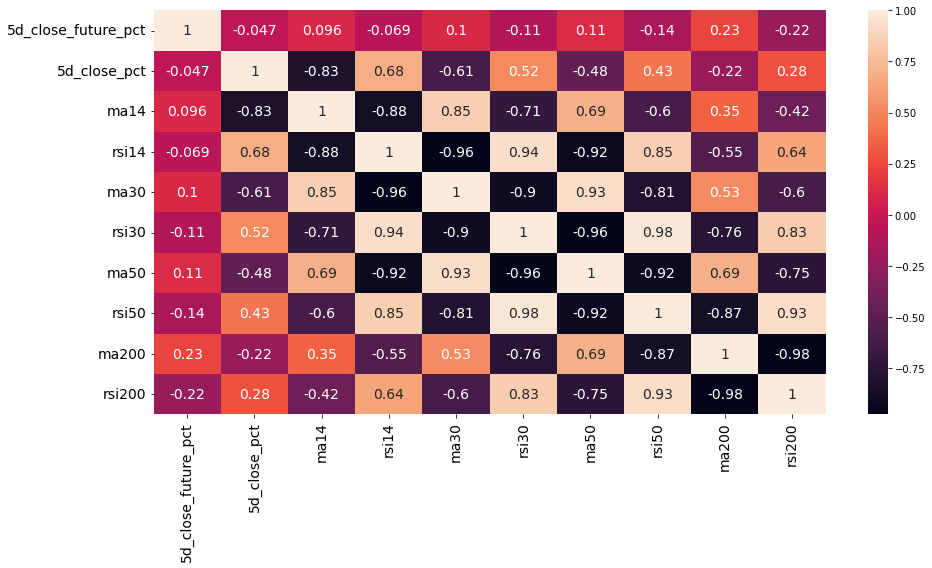

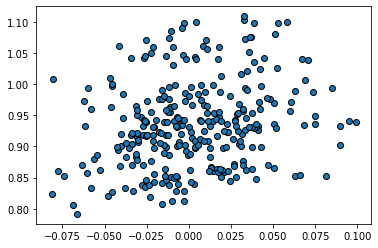

In [7]:
# Plot heatmap of correlation matrix
plt.figure(figsize=(14, 8))
sns.heatmap(corr, annot=True, annot_kws={"size": 14})
plt.yticks(rotation=0, size = 14); plt.xticks(rotation=90, size = 14)  # fix ticklabel directions and size
plt.tight_layout()  # fits plot area to the plot, "tightly"
plt.show()  # show the plot
plt.clf()  # clear the plot area

# Create a scatter plot of the most highly correlated variable with the target
plt.scatter(lng_df['5d_close_future_pct'], lng_df['ma200'], edgecolors='k')
plt.show()

We can see a few features have some correlation to the target!

# **Train-Test Financial Data**

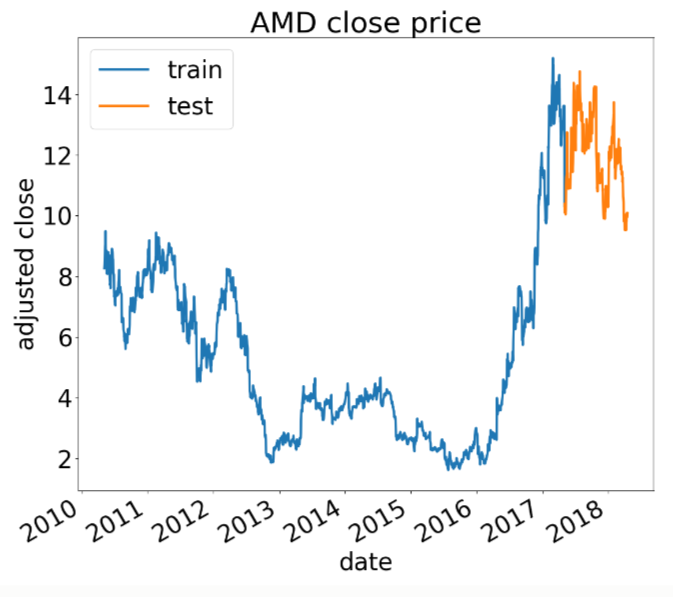


## ***Create train and test features***

Before we fit our linear model, we want to <ins>***add a constant***</ins> to our features, so we have an intercept for our linear model.

We also want to create train and test features. This is so we can fit our model to the train dataset, and evaluate performance on the test dataset. We always want to check performance on data the model has not seen to make sure we're not overfitting, which is memorizing patterns in the training data too exactly.

With a time series like this, we typically want to use the oldest data as our training set, and the newest data as our test set. This is so we can evaluate the performance of the model on the most recent data, which will more realistically simulate predictions on data we haven't seen yet.


* Add a constant to the features variable using **`statsmodels`**' **`.add_constant()`** function.

* Set `train_size` as 85% of the total number of datapoints (number of rows) using the `.shape[0]` property of features or targets.

* Break up `linear_features` and `targets` into train and test sets using `train_size` and Python indexing (e.g. `[start:stop]`).

In [8]:
import statsmodels.api as sm

# Add a constant to the features
linear_features = sm.add_constant(features)

# Create a size for the training set that is 85% of the total number of samples
train_size = int(0.85 * features.shape[0])
train_features = linear_features[:train_size]
train_targets = targets[:train_size]
test_features = linear_features[train_size:]
test_targets = targets[train_size:]
print(linear_features.shape, train_features.shape, test_features.shape)

(295, 10) (250, 10) (45, 10)


/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/tsatools.py:142: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only
  x = pd.concat(x[::order], 1)


## ***Fit a linear model***

We'll now fit a linear model, because they are simple and easy to understand. Once we've fit our model, we can see which predictor variables appear to be meaningfully linearly correlated with the target, as well as their magnitude of effect on the target. Our judgment of whether or not predictors are significant is based on the p-values of coefficients. This is using a t-test to statistically test if the coefficient significantly differs from 0. The p-value is the percent chance that the coefficient for a feature does not differ from zero. Typically, we take a p-value of less than 0.05 to mean the coefficient is significantly different from 0.


* Fit the linear model (using the `.fit()` method) and save the results in the `results` variable.

* Print out the results summary with the **`.summary()`** function.

* Print out the p-values from the results (the **`.pvalues`** property of results).

* Make predictions from the `train_features` and `test_features` using the **`.predict()`** function of our results object.

In [9]:
# Create the linear model and complete the least squares fit
model = sm.OLS(train_targets, train_features)
results = model.fit()  # fit the model
print(results.summary())

# examine pvalues
# Features with p <= 0.05 are typically considered significantly different from 0
print(results.pvalues)

# Make predictions from our model for train and test sets
train_predictions = results.predict(train_features)
test_predictions = results.predict(test_features)

                             OLS Regression Results                            
Dep. Variable:     5d_close_future_pct   R-squared:                       0.273
Model:                             OLS   Adj. R-squared:                  0.246
Method:                  Least Squares   F-statistic:                     10.01
Date:                 Sun, 11 Sep 2022   Prob (F-statistic):           4.92e-13
Time:                         17:26:18   Log-Likelihood:                 536.49
No. Observations:                  250   AIC:                            -1053.
Df Residuals:                      240   BIC:                            -1018.
Df Model:                            9                                         
Covariance Type:             nonrobust                                         
                   coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------
const            6.8197      1.169    

## ***Evaluate our results***

Once we have our linear fit and predictions, we want to see how good the predictions are so we can decide if our model is any good or not. Ideally, we want to back-test any type of trading strategy. However, this is a complex and typically time-consuming experience.

A quicker way to understand the performance of our model is looking at regression evaluation metrics like $R^2$, and plotting the predictions versus the actual values of the targets. Perfect predictions would form a straight, diagonal line in such a plot, making it easy for us to eyeball how our predictions are doing in different regions of price changes. We can use `matplotlib`'s **`.scatter()`** function to create scatter plots of the predictions and actual values.

* Show `test_predictions` vs `test_targets` in a scatterplot, with 20% opacity for the points (use the `alpha` parameter to set opacity).

* Plot the perfect prediction line using **`np.arange()`** and the minimum and maximum values from the xaxis (`xmin`, `xmax`).

* Display the legend on the plot with `plt.legend()`.

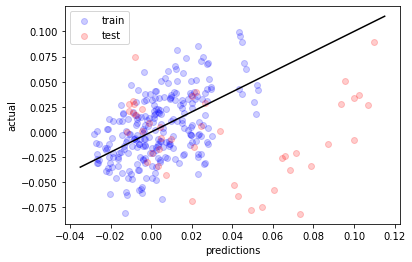

In [10]:
# Scatter the predictions vs the targets with 20% opacity
plt.scatter(train_predictions, train_targets, alpha=0.2, color='b', label='train')
plt.scatter(test_predictions, test_targets, alpha=0.2, color='r', label='test')

# Plot the perfect prediction line
xmin, xmax = plt.xlim()
plt.plot(np.arange(xmin, xmax, 0.01), np.arange(xmin, xmax, 0.01), c='k')

# Set the axis labels and show the plot
plt.xlabel('predictions')
plt.ylabel('actual')
plt.legend() # show the legend
plt.show()

We can see our predictions are ok, but not very good yet. We need non-linearity! 

## ***Feature engineering from volume***

We're going to use non-linear models to make more accurate predictions. With linear models, features must be linearly correlated to the target. Other machine learning models can combine features in non-linear ways. For example, what if the price goes up when the moving average of price is going up, and the moving average of volume is going down? The only way to capture those interactions is to either multiply the features, or to use a machine learning algorithm that can handle non-linearity (e.g. random forests).

To incorporate more information that may interact with other features, we can add in weakly-correlated features. First we will add volume data, which we have in the `lng_df` as the `Adj_Volume` column.

Before you begin, remember that for TA-Lib functions (such as **`SMA()`**), you need to provide Numpy arrays, not pandas objects. You can use the **`.values`** attribute of a pandas Series or DataFrame to return it as a Numpy array.

* Create a 1-day percent change in volume (use **`pct_change()`** from pandas), and assign it to the `Adj_Volume_1d_change` column in `lng_df`.

* Create a 5-day moving average of the 1-day percent change in Volume, and assign it to the `Adj_Volume_1d_change_SMA` column in `lng_df`.

* Plot histograms of these two new features we created using the `new_features` list.

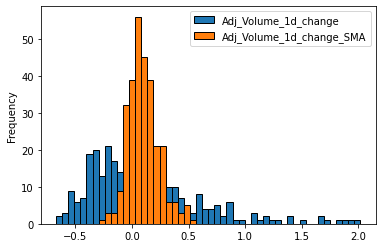

In [11]:
# Create 2 new volume features, 1-day % change and 5-day SMA of the % change
new_features = ['Adj_Volume_1d_change', 'Adj_Volume_1d_change_SMA']
feature_names.extend(new_features)
lng_df['Adj_Volume_1d_change'] = lng_df['Adj_Volume'].pct_change()
lng_df['Adj_Volume_1d_change_SMA'] = talib.SMA(lng_df['Adj_Volume_1d_change'].values,
                        timeperiod=5)

# Plot histogram of volume % change data
lng_df[new_features].plot(kind='hist', sharex=False, bins=50, edgecolor='k')
plt.show()

## ***Create day-of-week features***

We can engineer datetime features to add even more information for our non-linear models. Most financial data has datetimes, which have lots of information in them -- year, month, day, and sometimes hour, minute, and second. But we can also get the day of the week, and things like the quarter of the year, or the elapsed time since some event (e.g. earnings reports).

We are only going to get the day of the week here, since our dataset doesn't go back very far in time. The **`dayofweek`** property from the pandas datetime index will help us get the day of the week. Then we will dummy **`dayofweek`** with pandas' **`get_dummies()`**. This creates columns for each day of the week with binary values (0 or 1). We <ins>*drop the first column*</ins> because it can be inferred from the others.

* Use the **`dayofweek`** property from the `lng_df` index to get the days of the week.

* Use the **`get_dummies`** function on the days of the week variable, giving it a prefix of `'weekday'`.

* Set the index of the `days_of_week` variable to be the same as the `lng_df` index so we can merge the two.

* Concatenate the `lng_df` and `days_of_week` DataFrames into one DataFrame.

In [12]:
# Use pandas' get_dummies function to get dummies for day of the week
days_of_week = pd.get_dummies(lng_df.index.dayofweek,
                              prefix='weekday',
                              drop_first=True)

# Set the index as the original dataframe index for merging
days_of_week.index = lng_df.index

# Join the dataframe with the days of week dataframe
lng_df = pd.concat([lng_df, days_of_week], axis=1)

# Add days of week to feature names
feature_names.extend(['weekday_' + str(i) for i in range(1, 5)])
lng_df.dropna(inplace=True)  # drop missing values in-place
lng_df.head()

,Adj_Close,Adj_Volume,5d_future_close,5d_close_future_pct,5d_close_pct,ma14,rsi14,ma30,rsi30,ma50,rsi50,ma200,rsi200,Adj_Volume_1d_change,Adj_Volume_1d_change_SMA,weekday_1,weekday_2,weekday_3,weekday_4
Date,,,,,,,,,,,,,,,,,,,
2017-02-07,47.81,2523000.0,47.88,0.001464,0.003358,0.985448,58.654992,0.939476,58.817869,0.911801,57.123212,0.842290,53.629901,0.206600,0.104147,1,0,0,0
2017-02-08,48.01,1521000.0,47.69,-0.006665,0.019321,0.989333,59.351015,0.940047,59.182360,0.911289,57.364214,0.839954,53.694867,-0.397146,0.032673,0,1,0,0
2017-02-09,49.19,1718000.0,46.84,-0.047774,-0.002838,0.974211,63.278848,0.922383,61.274321,0.893214,58.759765,0.821018,54.076387,0.129520,-0.041716,0,0,1,0
2017-02-10,48.93,1748000.0,46.71,-0.045371,-0.010115,0.987957,61.860468,0.931821,60.566775,0.902031,58.330493,0.826385,53.977901,0.017462,-0.108136,0,0,0,1
2017-02-13,48.14,2322000.0,47.36,-0.016203,-0.007423,1.007864,57.633333,0.951371,58.445466,0.919859,57.038536,0.840935,53.679362,0.328375,0.056962,0,0,0,0


## ***Examine correlations of the new features***

Now that we have our volume and datetime features, we want to check the correlations between our new features (stored in the `new_features` list) and the target (`5d_close_future_pct`) to see how strongly they are related. Recall pandas has the built-in **`.corr()`** method for DataFrames, and `seaborn` has a nice **`heatmap()`** function to show the correlations.


* Extend our `new_features` variable to contain the weekdays' column names, such as `weekday_1`, by concatenating the weekday number with the `'weekday_'` string.

* Use Seaborn's **`heatmap`** to plot the correlations of `new_features` and the target, `5d_close_future_pct`.

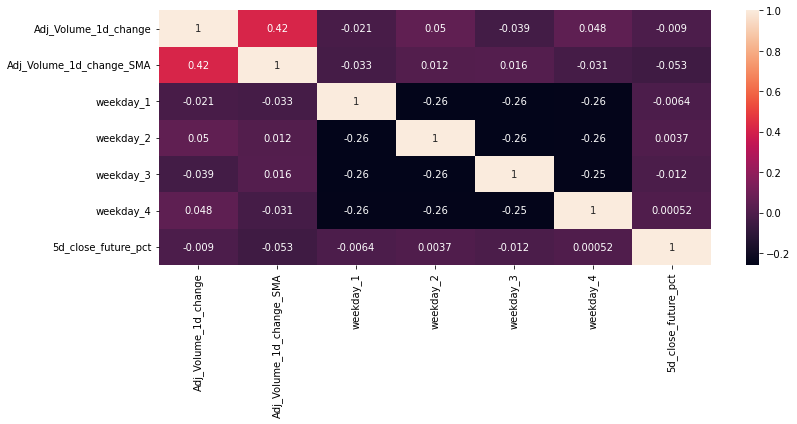

In [13]:
plt.figure(figsize=(12, 6))

# Add the weekday labels to the new_features list
new_features.extend(['weekday_' + str(i) for i in range(1, 5)])

# Plot the correlations between the new features and the targets
sns.heatmap(lng_df[new_features + ['5d_close_future_pct']].corr(), annot=True)
plt.yticks(rotation=0)  # ensure y-axis ticklabels are horizontal
plt.xticks(rotation=90)  # ensure x-axis ticklabels are vertical
plt.tight_layout()
plt.show()

 Even though the correlations are weak, they may improve our predictions via interactions with other features.

 # **Decision Trees**

 * Decision trees predict future price changes of securities

## ***Fit a decision tree***

Random forests are a go-to model for predictions; they work well out of the box. But we'll first learn the building block of random forests -- ***decision trees***.

Decision trees split the data into groups based on the features. Decision trees start with a root node, and split the data down until we reach leaf nodes.

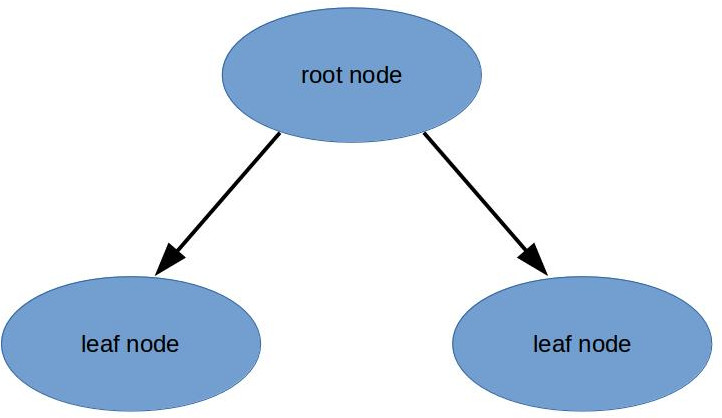

We can use `sklearn` to fit a decision tree with `DecisionTreeRegressor` and **`.fit(features, targets)`**.

Without limiting the tree's depth (or height), it will keep splitting the data until each leaf has 1 sample in it, which is the epitome of overfitting. We'll learn more about overfitting in the coming chapters.

* Use the imported class `DecisionTreeRegressor` with default arguments (i.e. no arguments) to create a decision tree model called `decision_tree`.

* Fit the model using `train_features` and `train_targets` which we've created earlier (and now contain day-of-week and volume features).

* Print the score on the training features and targets, as well as `test_features` and `test_targets`.

In [14]:
from sklearn.tree import DecisionTreeRegressor

# Create a decision tree regression model with default arguments
decision_tree = DecisionTreeRegressor()

# Fit the model to the training features and targets
decision_tree.fit(train_features, train_targets)

# Check the score on train and test
print(decision_tree.score(train_features, train_targets))
print(decision_tree.score(test_features, test_targets))

1.0
-1.665900816496312


A perfect fit! ...on the training data.

## ***Try different max depths***

We always want to optimize our machine learning models to make the best predictions possible. We can do this by tuning hyperparameters, which are settings for our models. We will see in more detail how these are useful in future chapters, but for now think of them as knobs we can turn to tune our predictions to be as good as possible.

For regular decision trees, probably the most important hyperparameter is **`max_depth`**. This limits the number of splits in a decision tree. Let's find the best value of `max_depth` based on the $R^2$ score of our model on the test set, which we can obtain using the **`.score()`** method of our decision tree models.

* Loop through the values 3, 5, and 10 for use as the **`max_depth`** parameter in our decision tree model.

* Set the **`max_depth`** parameter in our `DecisionTreeRegressor` to be equal to `d` in each loop iteration.

* Print the model's score on the `train_features` and `train_targets`.

In [15]:
# Loop through a few different max depths and check the performance
for d in [3, 5, 10]:
    # Create the tree and fit it
    decision_tree = DecisionTreeRegressor(max_depth=d)
    decision_tree.fit(train_features, train_targets)

    # Print out the scores on train and test
    print('max_depth=', str(d))
    print(decision_tree.score(train_features, train_targets))
    print(decision_tree.score(test_features, test_targets), '\n')

max_depth= 3
0.31221074754988065
-0.34425820543875796 

max_depth= 5
0.5300236519892909
-0.9073657448150776 

max_depth= 10
0.8969996678254253
-1.250490126991834 



## ***Check our results***

Once we have an optimized model, we want to check how it is performing in more detail. We already saw the $R^2$ score, but it can be helpful to see the predictions plotted vs actual values. We can use the **`.predict()`** method of our decision tree model to get predictions on the train and test sets.

Ideally, we want to see diagonal lines from the lower left to the upper right. However, due to the simplicity of decisions trees, our model is not going to do well on the test set. But it will do well on the train set.

* Create a **`DecisionTreeRegressor`** model called `decision_tree` using `3` for the **`max_depth`** hyperparameter.

* Make predictions on the train and test sets (`train_features` and `test_features`) with our decision tree model.

* Scatter the train and test predictions vs the actual target values with **`plt.scatter()`**, and set the `label` argument equal to `test` for the test set.

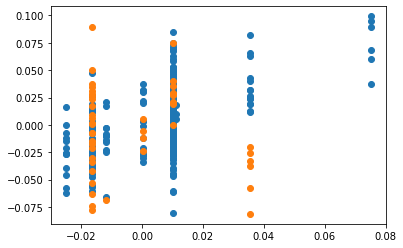

In [16]:
# Use the best max_depth of 3 from last exercise to fit a decision tree
decision_tree = DecisionTreeRegressor(max_depth=3)
decision_tree.fit(train_features, train_targets)

# Predict values for train and test
train_predictions = decision_tree.predict(train_features)
test_predictions =decision_tree.predict(test_features)

# Scatter the predictions vs actual values
plt.scatter(train_predictions, train_targets, label='train')
plt.scatter(test_predictions, test_targets, label='test')
plt.show()

The predictions group into *lines* because our depth is limited.

## ***Fit a random forest***

Data scientists often use random forest models. They perform well out of the box, and have lots of settings to optimize performance. Random forests can be used for classification or regression; we'll use it for regression to predict the future price change of LNG.

We'll create and fit the random forest model similarly to the decision trees using the **`.fit(features, targets)`** method. With `sklearn`'s **`RandomForestRegressor`**, there's a built-in **`.score()`** method we can use to evaluate performance. This takes arguments `(features, targets)`, and returns the $R^2$ score (the coefficient of determination).

* Fit (train) the random forest using `train_features` and `train_targets`.
* Print out the $R^2$ score on the train and test sets.

In [17]:
from sklearn.ensemble import RandomForestRegressor

# Create the random forest model and fit to the training data
rfr = RandomForestRegressor(n_estimators=200)
rfr.fit(train_features, train_targets)

# Look at the R^2 scores on train and test
print(rfr.score(train_features, train_targets))
print(rfr.score(test_features, test_targets))

0.9170949394607502
-0.05749333021931169


Now let's tune the hyperparameters for better performance.

## ***Tune random forest hyperparameters***

As with all models, we want to optimize performance by tuning hyperparameters. We have many hyperparameters for random forests, but the most important is often the number of features we sample at each split, or **`max_features`** in `RandomForestRegressor` from the `sklearn` library. For models like random forests that have randomness built-in, we also want to set the **`random_state`**. This is set for our results to be reproducible.

Usually, we can use `sklearn`'s **`GridSearchCV()`** method to search hyperparameters, but with a financial time series, we don't want to do cross-validation due to data mixing. We want to fit our models on the oldest data and evaluate on the newest data. So we'll use `sklearn`'s **`ParameterGrid`** to create combinations of hyperparameters to search.

* Set the **`n_estimators`** hyperparameter to be a list with one value (`200`) in the `grid` dictionary.

* Set the **`max_features`** hyperparameter to be a list containing 4 and 8 in the `grid` dictionary.

* Fit the random forest regressor model  to the train_features and `train_targets` with each combination of hyperparameters, `g`, in the loop.

* Calculate $R^2$ by using **`rfr.score()`** on `test_features` and append the result to the `test_scores` list.

In [18]:
from sklearn.model_selection import ParameterGrid
rfr = RandomForestRegressor()

# Create a dictionary of hyperparameters to search
grid = {'n_estimators':[200], 'max_depth': [3], 'max_features': [4, 8], 'random_state': [42]}
test_scores = []

# Loop through the parameter grid, set the hyperparameters, and save the scores
for g in ParameterGrid(grid):
    rfr.set_params(**g)  # ** is "unpacking" the dictionary
    rfr.fit(train_features, train_targets)
    test_scores.append(rfr.score(test_features, test_targets))

# Find best hyperparameters from the test score and print
best_idx = np.argmax(test_scores)
print(test_scores[best_idx], ParameterGrid(grid)[best_idx])

0.03463037963408222 {'random_state': 42, 'n_estimators': 200, 'max_features': 4, 'max_depth': 3}


Our test score ($R^2$) isn't great, but it's greater than 0!

## ***Evaluate performance***

Lastly, and as always, we want to evaluate performance of our best model to check how well or poorly we are doing. Ideally it's best to do back-testing, but that's an involved process we don't have room to cover in this course.

We've already seen the $R^2$ scores, but let's take a look at the scatter plot of predictions vs actual results using `matplotlib`. Perfect predictions would be a diagonal line from the lower left to the upper right.

* Use the best number for `max_features` in our `RandomForestRegressor` (`rfr`) that we found in the previous exercise (it was `4`).

* Make predictions using the model with the `train_features` and `test_features`.

* Scatter actual targets (`train/test_targets`) vs the predictions (`train/test_predictions`), and label the datasets `train` and `test`.

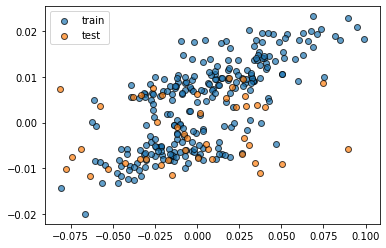

In [19]:
# Use the best hyperparameters from before to fit a random forest model
rfr = RandomForestRegressor(n_estimators=200, max_depth=3, max_features=4, random_state=42)
rfr.fit(train_features, train_targets)

# Make predictions with our model
train_predictions = rfr.predict(train_features)
test_predictions = rfr.predict(test_features)

# Create a scatter plot with train and test actual vs predictions
plt.scatter(train_targets, train_predictions, label='train', edgecolor='k', alpha=0.7)
plt.scatter(test_targets, test_predictions, label='test', edgecolor='k', alpha=0.7)
plt.legend()
plt.show()

We can see our train predictions are good, but test predictions (generalization) are not great.

## ***Random forest feature importances***

One useful aspect of tree-based methods is the ability to extract feature importances. This is a quantitative way to measure how much each feature contributes to our predictions. It can help us focus on our best features, possibly enhancing or tuning them, and can also help us get rid of useless features that may be cluttering up our model.

Tree models in `sklearn` have a **`.feature_importances_`** property that's accessible after fitting the model. This stores the feature importance scores. We need to get the indices of the sorted feature importances using **`np.argsort()`** in order to make a nice-looking bar plot of feature importances (sorted from greatest to least importance).

* Use the **`.feature_importances_`** property of our random forest model (`rfr`) to extract feature importances into the importances variable.

* Use `numpy`'s **`argsort`** to get indices of the feature importances from greatest to least, and save the sorted indices in the `sorted_index` variable.

* Set xtick labels to be feature names in the `labels` variable, using the `sorted_index` list. `feature_names` must be converted to a `numpy` array so we can index it with the `sorted_index` list.

# ที่ก่อนหน้านี้มีคลาดเคลื่อนกันเล็กน้อย เพราะไม่ได้ใส่ weekday ลงไปด้วย


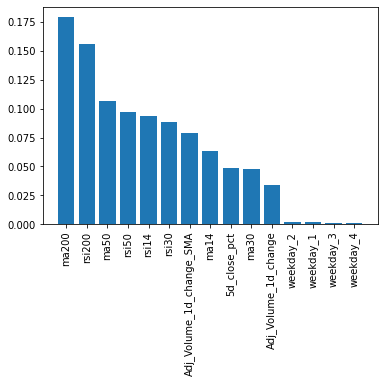

In [20]:
features = lng_df[feature_names]
targets = lng_df['5d_close_future_pct']
train_features = features[:train_size]
train_targets = targets[:train_size]
test_features = features[train_size:]
test_targets = targets[train_size:]

# Get feature importances from our random forest model
rfr = RandomForestRegressor(n_estimators=200, max_depth=3, max_features=4, random_state=42)
rfr.fit(train_features, train_targets)
importances = rfr.feature_importances_

# Get the index of importances from greatest importance to least
sorted_index =np.argsort(importances)[::-1]
x = range(len(importances))

# Create tick labels 
labels = np.array(feature_names)[sorted_index]
plt.bar(x, importances[sorted_index], tick_label=labels)

# Rotate tick labels to vertical
plt.xticks(rotation=90)
plt.show()

Unsurprisingly, it looks like the days of the week should be thrown out.

## ***A gradient boosting model***

GB is similar to random forest models, but the difference is that trees are built successively. With each iteration, the next tree fits the residual errors from the previous tree in order to improve the fit.

For now we won't search our hyperparameters -- they've been searched for you.


* Fit the `gbr` model to the `train_features` and `train_targets`.
* Print the scores for the training and test features and targets.

In [21]:
from sklearn.ensemble import GradientBoostingRegressor

# Create GB model -- hyperparameters have already been searched for you
gbr = GradientBoostingRegressor(max_features=4,
                                learning_rate=0.01,
                                n_estimators=200,
                                subsample=0.6,
                                random_state=42)
gbr.fit(train_features, train_targets)

print(gbr.score(train_features, train_targets))
print(gbr.score(test_features, test_targets))

0.4188532362777124
0.0706888286863836


In this case the gradient boosting model isn't that much better than a random forest, but you know what they say -- no free lunch!

## ***Gradient boosting feature importances***

As with random forests, we can extract feature importances from gradient boosting models to understand which features are the best predictors. Sometimes it's nice to try different tree-based models and look at the feature importances from all of them. This can help average out any peculiarities that may arise from one particular model.

The feature importances are stored as a numpy array in the **`.feature_importances_`** property of the gradient boosting model. We'll need to get the sorted indices of the feature importances, using **`np.argsort()`**, in order to make a nice plot. We want the features from largest to smallest, so we will use Python's indexing to reverse the sorted importances like `feat_importances[::-1]`.

* Reverse the `sorted_index` variable to go from greatest to least using python indexing.

* Create the sorted feature labels list as `labels` by converting `feature_names` to a numpy array and indexing with `sorted_index`.

* Create a bar plot of the xticks, and `feature_importances` indexed with the `sorted_index` variable, and `labels` as the xtick labels.



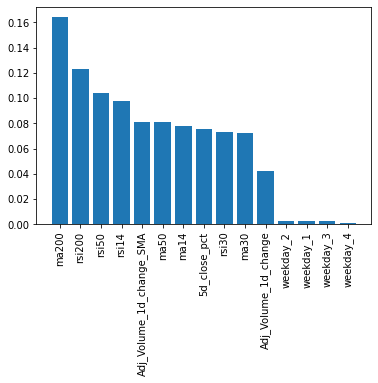

In [22]:
# Extract feature importances from the fitted gradient boosting model
feature_importances = gbr.feature_importances_

# Get the indices of the largest to smallest feature importances
sorted_index = np.argsort(feature_importances)[::-1]
x = range(features.shape[1])

# Create tick labels 
labels = np.array(feature_names)[sorted_index]

plt.bar(x, feature_importances[sorted_index], tick_label=labels)

# Set the tick lables to be the feature names, according to the sorted feature_idx
plt.xticks(rotation=90)
plt.show()

Notice the feature importances are not exactly the same as the random forest model's...but they're close.

# **Scaling for KNN**

* ถ้าตัวแปรใดตัวนึงมันมีขนาดช่วงข้อมูลที่ใหญ่กว่าอีกตัวแปรนึงมากๆ จะทำให้การใช้ KNN ไม่มีประสิทธิภาพ ดังรูปประกอบ

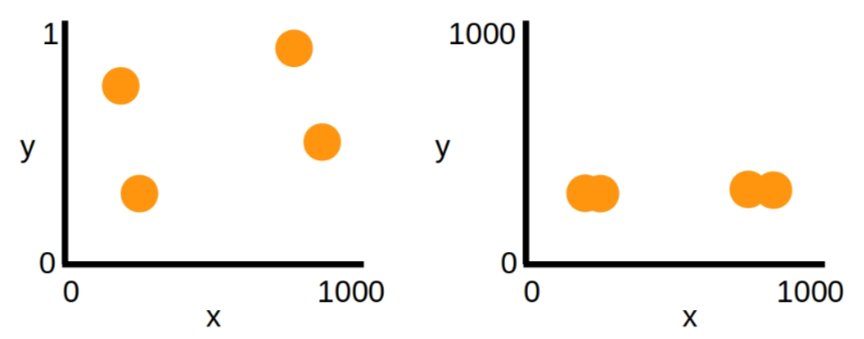

## ***Standardizing data***

Some models, like K-nearest neighbors (KNN) & neural networks, work better with scaled data -- so we'll standardize our data.

We'll also remove unimportant variables (day of week), according to feature importances, by indexing the features DataFrames with `.iloc[]`. KNN uses distances to find similar points for predictions, so big features outweigh small ones. Scaling data fixes that.

`sklearn`'s **`scale()`** will standardize data, which sets the mean to 0 and standard deviation to 1. Ideally we'd want to use **`StandardScaler`** with **`.fit_transform()`** on the training data, and **`.fit()`** on the test data, but we are limited to 15 lines of code here.

Once we've scaled the data, we'll check that it worked by plotting histograms of the data.

* Remove day of week features from train/test features using `.iloc` (day of week are the last 4 features).

* Standardize `train_features` and `test_features` using `sklearn`'s **`.scale()`**; store scaled features as `scaled_train_features` and `scaled_test_features`.

* Plot a histogram of the 14-day RSI moving average (indexed at `[:, 2]`) from unscaled `train_features` on the first subplot (`ax[0]`).

* Plot a histogram of the standardized 14-day RSI moving average on the second subplot (`ax[1]`).



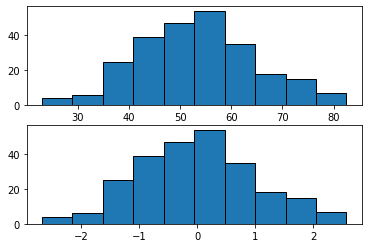

In [23]:
from sklearn.preprocessing import scale

# Remove unimportant features (weekdays)
train_features = train_features.iloc[:, :-4]
test_features = test_features.iloc[:, :-4]

# Standardize the train and test features
scaled_train_features = scale(train_features)
scaled_test_features = scale(test_features)

# Plot histograms of the 14-day SMA RSI before and after scaling
f, ax = plt.subplots(nrows=2, ncols=1)
train_features.iloc[:, 2].hist(ax=ax[0], edgecolor='k', grid=False)
ax[1].hist(scaled_train_features[:, 2], edgecolor='k')
plt.show()

Next we're going to optimize n_neighbors for improved performance.

## ***Optimize n_neighbors***

Now that we have scaled data, we can try using a KNN model. To maximize performance, we should tune our model's hyperparameters. For the k-nearest neighbors algorithm, we only have one hyperparameter: **`n`**, the number of neighbors. We set this hyperparameter when we create the model with **`KNeighborsRegressor`**. The argument for the number of neighbors is `n_neighbors`.

We want to try a range of values that passes through the setting with the best performance. Usually we will start with `2` neighbors, and increase until our scoring metric starts to decrease. We'll use the $R^2$ value from the **`.score()`** method on the test set (`scaled_test_features` and `test_targets`) to optimize **`n`** here. We'll use the test set scores to determine the best **`n`**.

* Loop through values of `2` to `12` for **`n`** and set this as `n_neighbors` in the `knn` model.

* Fit the model to the training data (`scaled_train_features` and `train_targets`).

* Print out the $R^2$ values using the **`.score()`** method of the `knn` model for the train and test sets, and take note of the best score on the test set.

In [24]:
from sklearn.neighbors import KNeighborsRegressor

for n in range(2, 13):
    # Create and fit the KNN model
    knn = KNeighborsRegressor(n_neighbors=n)
    
    # Fit the model to the training data
    knn.fit(scaled_train_features, train_targets)
    
    # Print number of neighbors and the score to find the best value of n
    print("n_neighbors =", n)
    print('train, test scores')
    print(knn.score(scaled_train_features, train_targets))
    print(knn.score(scaled_test_features, test_targets))
    print()  # prints a blank line

n_neighbors = 2
train, test scores
0.7131572689394713
-0.3721165334141803

n_neighbors = 3
train, test scores
0.6358500682798828
-0.11708276643909721

n_neighbors = 4
train, test scores
0.5885146922217506
-0.09395932758055725

n_neighbors = 5
train, test scores
0.549473330284318
-0.08432904352743598

n_neighbors = 6
train, test scores
0.5196827710713887
-0.03298484006201341

n_neighbors = 7
train, test scores
0.48088893097148266
-0.016633437749496327

n_neighbors = 8
train, test scores
0.4368663685883494
0.010082235026292463

n_neighbors = 9
train, test scores
0.4024981489436762
0.04352977279015735

n_neighbors = 10
train, test scores
0.3564060380971389
0.0019985010949350457

n_neighbors = 11
train, test scores
0.3130199716194667
-0.0058104513736867425

n_neighbors = 12
train, test scores
0.26983386643651464
0.03171248101060464



See how 9 is the best number of neighbors based on the test scores?

## ***Evaluate KNN performance***

We just saw a few things with our KNN scores. For one, the <ins>*training*</ins> scores started high and decreased with increasing `n`, which is typical. The <ins>*test*</ins> set performance reached a peak at `9` though, and we will use that as our setting in the final KNN model.

As we have done a few times now, we will check our performance visually. This helps us see how well the model is predicting on different regions of actual values. We will get predictions from our `knn` model using the **`.predict()`** method on our scaled features. Then we'll use `matplotlib`'s **`plt.scatter()`** to create a scatter plot of actual versus predicted values.

* Set `n_neighbors` in the **`KNeighborsRegressor`** to the best-performing value of 9 (found in the previous exercise).

* Obtain predictions using the `knn` model from the `scaled_train_features` and `scaled_test_features`.

* Create a scatter plot of the `test_targets` versus the `test_predictions` and label it `test`.

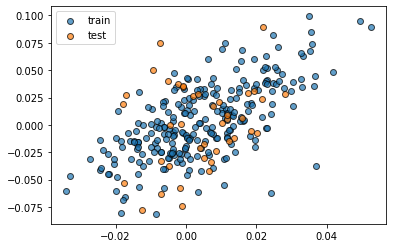

In [25]:
# Create the model with the best-performing n_neighbors of 9
knn = KNeighborsRegressor(n_neighbors=9)

# Fit the model
knn.fit(scaled_train_features, train_targets)

# Get predictions for train and test sets
train_predictions = knn.predict(scaled_train_features)
test_predictions = knn.predict(scaled_test_features)

# Plot the actual vs predicted values
plt.scatter(train_predictions, train_targets, label='train', edgecolor='k', alpha=0.7)
plt.scatter(test_predictions, test_targets, label='test', edgecolor='k', alpha=0.7)
plt.legend()
plt.show()

The model is doing OK!

## ***Build and fit a simple neural net***

The next model we will learn how to use is a neural network. Neural nets can capture complex interactions between variables, but are difficult to set up and understand. Recently, they have been beating human experts in many fields, including image recognition and gaming (check out AlphaGo) -- so they have great potential to perform well.

To build our nets we'll use the **`keras`** library. This is a high-level API that allows us to quickly make neural nets, yet still exercise a lot of control over the design. The first thing we'll do is create almost the simplest net possible -- a 3-layer net that takes our inputs and predicts a single value. Much like the `sklearn` models, **keras** models have a **`.fit()`** method that takes arguments of (`features, targets`).


* Create a dense layer with `20` nodes and the ReLU (`'relu'`) activation as the second layer in the neural network.

* Create the last dense layer with `1` node and a linear activation (`activation='linear'`).

* Fit the model to the `scaled_train_features` and `train_targets`.

In [26]:
from keras.models import Sequential
from keras.layers import Dense

# Create the model
model_1 = Sequential()
model_1.add(Dense(100, input_dim=scaled_train_features.shape[1], activation='relu'))
model_1.add(Dense(20, activation='relu'))
model_1.add(Dense(1, activation='linear'))

# Fit the model
model_1.compile(optimizer='adam', loss='mse')
history = model_1.fit(scaled_train_features, train_targets, epochs=25)

Epoch 1/25
8/8 [==============================] - 1s 4ms/step - loss: 0.1383
Epoch 2/25
8/8 [==============================] - 0s 3ms/step - loss: 0.0390
Epoch 3/25
8/8 [==============================] - 0s 3ms/step - loss: 0.0170
Epoch 4/25
8/8 [==============================] - 0s 4ms/step - loss: 0.0138
Epoch 5/25
8/8 [==============================] - 0s 3ms/step - loss: 0.0079
Epoch 6/25
8/8 [==============================] - 0s 4ms/step - loss: 0.0060
Epoch 7/25
8/8 [==============================] - 0s 3ms/step - loss: 0.0045
Epoch 8/25
8/8 [==============================] - 0s 3ms/step - loss: 0.0035
Epoch 9/25
8/8 [==============================] - 0s 3ms/step - loss: 0.0033
Epoch 10/25
8/8 [==============================] - 0s 3ms/step - loss: 0.0028
Epoch 11/25
8/8 [==============================] - 0s 3ms/step - loss: 0.0026
Epoch 12/25
8/8 [==============================] - 0s 4ms/step - loss: 0.0023
Epoch 13/25
8/8 [==============================] - 0s 3ms/step - loss: 0.

Now we need to check that our training loss has flattened out and the net is sufficiently trained.

## ***Plot losses***

Once we've fit a model, we usually check the training loss curve to make sure it's flattened out. The history returned from `model.fit()` is a dictionary that has an entry, `'loss'`, which is the training loss. We want to ensure this has more or less flattened out at the end of our training.

* Plot the losses (`'loss'`) from **`history.history`**.
* Set the title of the plot as the last loss from **`history.history`**, and round it to 6 digits.

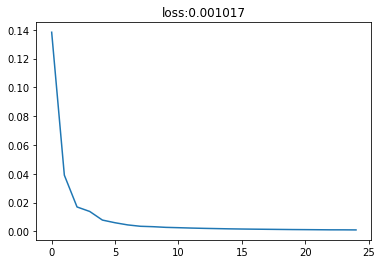

In [27]:
# Plot the losses from the fit
plt.plot(history.history['loss'])

# Use the last loss as the title
plt.title('loss:' + str(round(history.history['loss'][-1], 6)))
plt.show()

We can see our loss has flattened out, so we're good!

## ***Measure performance***

Now that we've fit our neural net, let's check performance to see how well our model is predicting new values. There's not a built-in **`.score()`** method like with `sklearn` models, so we'll use the **`r2_score()`** function from `sklearn.metrics`. This calculates the $R^2$ score given arguments (`y_true`, `y_predicted`). We'll also plot our predictions versus actual values again. This will yield some interesting results soon (once we implement our own custom loss function).

* Obtain predictions from `model_1` on the scaled test set data (`scaled_test_features` and `test_targets`).

* Print the $R^2$ score on the test set (`test_targets` and `test_preds`).
* Plot the `test_preds` versus `test_targets` in a scatter plot with `plt.scatter()`.

0.18506096210180167
-1.5644129878516209


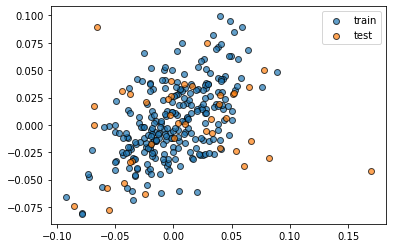

In [28]:
from sklearn.metrics import r2_score

# Calculate R^2 score
train_preds = model_1.predict(scaled_train_features)
test_preds = model_1.predict(scaled_test_features)
print(r2_score(train_targets, train_preds))
print(r2_score(test_targets, test_preds))

# Plot predictions vs actual
plt.scatter(train_preds, train_targets, label='train', edgecolor='k', alpha=0.7)
plt.scatter(test_preds,  test_targets,  label='test', edgecolor='k', alpha=0.7)
plt.legend()
plt.show()

It doesn't look too much different from our other models at this point.

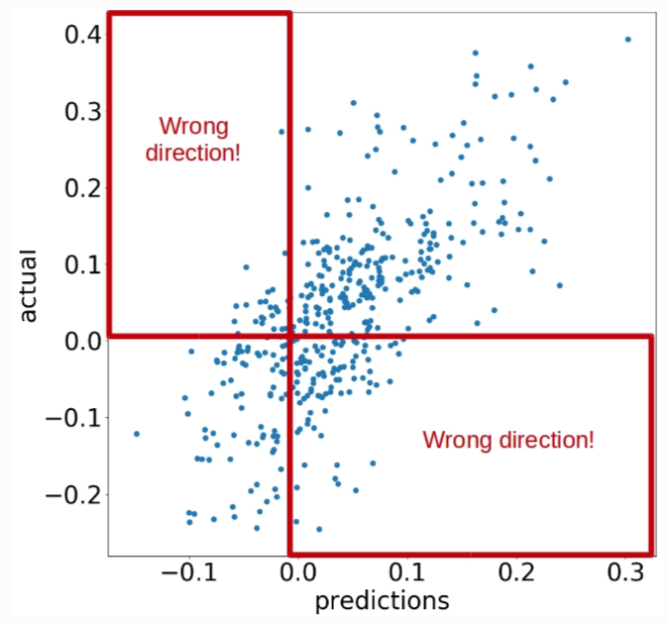

# **Checking for correct direction**




In [29]:
import tensorflow as tf

# tf.less(y_true * y_pred, 0)

Correct direction

* neg * neg = pos
* pos * pos = pos

Wrong direction

* neg * pos = neg
* pos * neg = neg

## ***Custom loss function***

Up to now, we've used the mean squared error as a loss function. This works fine, but with stock price prediction it can be useful to implement a custom loss function. A custom loss function can help improve our model's performance in specific ways we choose. For example, we're going to create a custom loss function with a large penalty for predicting price movements in the wrong direction. This will help our net learn to at least predict price movements in the correct direction.

To do this, we need to write a function that takes arguments of `(y_true, y_predicted)`. We'll also use functionality from the backend **`keras`** (using **`tensorflow`**) to find cases where the true value and prediction don't match signs, then penalize those cases.


* Set the arguments of the `sign_penalty()` function to be `y_true` and `y_pred`.

* Multiply the squared error (**`tf.square(y_true - y_pred)`**) by `penalty` when the signs of `y_true` and` y_pred` are different.

* Return the average of the `loss` variable from the function -- this is the mean squared error (with our penalty for opposite signs of actual vs predictions).

In [30]:
import keras.losses
import tensorflow as tf

# Create loss function
def sign_penalty(y_true, y_pred):
    penalty = 100.
    loss = tf.where(tf.less(y_true * y_pred, 0), \
                     penalty * tf.square(y_true - y_pred), \
                     tf.square(y_true - y_pred))

    return tf.reduce_mean(loss, axis=-1)

keras.losses.sign_penalty = sign_penalty  # enable use of loss with keras
print(keras.losses.sign_penalty)

<function sign_penalty at 0x7fa0cec9b830>


Now we'll see how that loss function affects our predictions.

## ***Fit neural net with custom loss function***

Now we'll use the custom loss function we just created. This will enable us to alter the model's behavior in useful ways particular to our problem -- it's going to try to force the model to learn how to at least predict price movement direction correctly. All we need to do now is set the loss argument in our **`.compile()`** function to our function name, `sign_penalty`. We'll examine the training loss again to make sure it's flattened out.

* Set the `input_dim` of the first neural network layer to be the number of columns of `scaled_train_features` with the `.shape[1]` property.

* Use the custom `sign_penalty` loss function to **`.compile()`** our `model_2`.

* Plot the loss from the history of the fit. The loss is under `history.history['loss']`.

Epoch 1/25
8/8 [==============================] - 1s 3ms/step - loss: 2.5893
Epoch 2/25
8/8 [==============================] - 0s 3ms/step - loss: 0.9992
Epoch 3/25
8/8 [==============================] - 0s 3ms/step - loss: 0.5948
Epoch 4/25
8/8 [==============================] - 0s 3ms/step - loss: 0.3333
Epoch 5/25
8/8 [==============================] - 0s 4ms/step - loss: 0.2739
Epoch 6/25
8/8 [==============================] - 0s 4ms/step - loss: 0.1754
Epoch 7/25
8/8 [==============================] - 0s 4ms/step - loss: 0.1212
Epoch 8/25
8/8 [==============================] - 0s 4ms/step - loss: 0.1052
Epoch 9/25
8/8 [==============================] - 0s 3ms/step - loss: 0.0846
Epoch 10/25
8/8 [==============================] - 0s 5ms/step - loss: 0.0800
Epoch 11/25
8/8 [==============================] - 0s 4ms/step - loss: 0.0750
Epoch 12/25
8/8 [==============================] - 0s 3ms/step - loss: 0.0599
Epoch 13/25
8/8 [==============================] - 0s 4ms/step - loss: 0.

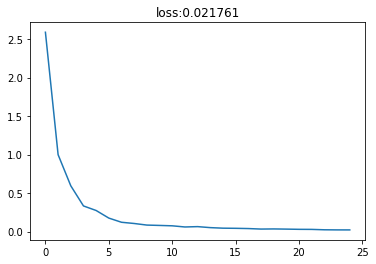

In [31]:
# Create the model
model_2 = Sequential()
model_2.add(Dense(100, input_dim=scaled_train_features.shape[1], activation='relu'))
model_2.add(Dense(20, activation='relu'))
model_2.add(Dense(1, activation='linear'))

# Fit the model with our custom 'sign_penalty' loss function
model_2.compile(optimizer='adam', loss=sign_penalty)
history = model_2.fit(scaled_train_features, train_targets, epochs=25)
plt.plot(history.history['loss'])
plt.title('loss:' + str(round(history.history['loss'][-1], 6)))
plt.show()

Now let's see how that changed the predictions.

## ***Visualize the results***

We've fit our model with the custom loss function, and it's time to see how it is performing. We'll check the $R^2$ values again with `sklearn`'s **`r2_score()`** function, and we'll create a scatter plot of predictions versus actual values with `plt.scatter()`. This will yield some interesting results!


* Create predictions on the test set with **`.predict()`**, `model_2`, and s`caled_test_features`.

* Evaluate the $R^2$ score on the test set predictions using `test_preds` and `test_targets`.

* Plot the test set targets vs actual values with `plt.scatter()`, and label it `'test'`.

-0.19864022499928802
-1.3767930021620876


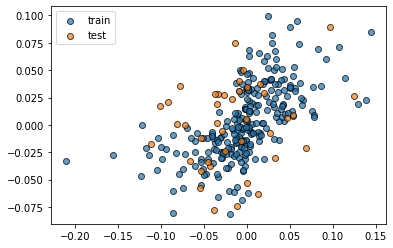

In [32]:
# Evaluate R^2 scores
train_preds = model_2.predict(scaled_train_features)
test_preds = model_2.predict(scaled_test_features)
print(r2_score(train_targets, train_preds))
print(r2_score(test_targets, test_preds))

# Scatter the predictions vs actual -- this one is interesting!
plt.scatter(train_preds, train_targets, label='train', edgecolor='k', alpha=0.7)
plt.scatter(test_preds, test_targets, label='test', edgecolor='k', alpha=0.7)  # plot test set
plt.legend(); plt.show()

Notice how the train set actual vs predictions shape has changed to be a bow-tie.

### *จะสังเกตเห็นได้ว่า ค่า $R^2$ แทบทุกอันของ test sets ติดลบ คือ เกิด overfitting ขึ้น*

## ***Combatting overfitting with dropout***

A common problem with neural networks is they tend to *overfit to training data*. What this means is the scoring metric, like $R^2$ or accuracy, is high for the training set, but low for testing and validation sets, and the model is fitting to noise in the training data.

We can work towards preventing overfitting by using **`dropout`**. This randomly drops some neurons during the training phase, which helps prevent the net from fitting noise in the training data. keras has a Dropout layer that we can use to accomplish this. We need to set the dropout rate, or fraction of connections dropped during training time. This is set as a decimal between 0 and 1 in the **`Dropout()`** layer.

We're going to go back to the mean squared error loss function for this model.

* Add a dropout layer (**`Dropout()`**) after the first Dense layer in the model, and use 20% (`0.2`) as the dropout rate.
* Use the `adam` optimizer and the `mse` loss function when compiling the model in **`.compile()`**.

* Fit the model to the `scaled_train_features` and `train_targets` using 25 epochs.

Epoch 1/25
8/8 [==============================] - 1s 4ms/step - loss: 0.0869
Epoch 2/25
8/8 [==============================] - 0s 3ms/step - loss: 0.0692
Epoch 3/25
8/8 [==============================] - 0s 3ms/step - loss: 0.0357
Epoch 4/25
8/8 [==============================] - 0s 4ms/step - loss: 0.0306
Epoch 5/25
8/8 [==============================] - 0s 3ms/step - loss: 0.0332
Epoch 6/25
8/8 [==============================] - 0s 4ms/step - loss: 0.0271
Epoch 7/25
8/8 [==============================] - 0s 3ms/step - loss: 0.0165
Epoch 8/25
8/8 [==============================] - 0s 4ms/step - loss: 0.0191
Epoch 9/25
8/8 [==============================] - 0s 4ms/step - loss: 0.0180
Epoch 10/25
8/8 [==============================] - 0s 3ms/step - loss: 0.0139
Epoch 11/25
8/8 [==============================] - 0s 3ms/step - loss: 0.0109
Epoch 12/25
8/8 [==============================] - 0s 3ms/step - loss: 0.0152
Epoch 13/25
8/8 [==============================] - 0s 4ms/step - loss: 0.

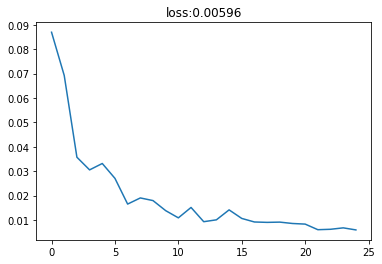

In [33]:
from keras.layers import Dropout

# Create model with dropout
model_3 = Sequential()
model_3.add(Dense(100, input_dim=scaled_train_features.shape[1], activation='relu'))
model_3.add(Dropout(0.2))
model_3.add(Dense(20, activation='relu'))
model_3.add(Dense(1, activation='linear'))

# Fit model with mean squared error loss function
model_3.compile(optimizer='adam', loss='mse')
history = model_3.fit(scaled_train_features, train_targets, epochs=25)
plt.plot(history.history['loss'])
plt.title('loss:' + str(round(history.history['loss'][-1], 6)))
plt.show()

Dropout helps the model generalized a bit better to unseen data.

## ***Ensembling models***

One approach to improve predictions from machine learning models is ensembling. A basic approach is to average the predictions from multiple models. A more complex approach is to feed predictions of models into another model, which makes final predictions. Both approaches usually improve our overall performance (as long as our individual models are good). If you remember, random forests are also using ensembling of many decision trees.

To ensemble our neural net predictions, we'll make predictions with the 3 models we just created -- the basic model, the model with the custom loss function, and the model with dropout. Then we'll combine the predictions with numpy's **`.hstack()`** function, and average them across rows with `np.mean(predictions, axis=1)`.

* Create predictions on the `scaled_train_features` and `scaled_test_features` for the 3 models we fit `(model_1, model_2, model_3)` using the **`.predict()`** method.

* Horizontally stack (**`np.hstack()`** the predictions into a matrix, and take the row-wise averages to get average predictions for the train and test sets.

In [34]:
# Make predictions from the 3 neural net models
train_pred1 = model_1.predict(scaled_train_features)
test_pred1 = model_1.predict(scaled_test_features)

train_pred2 = model_2.predict(scaled_train_features)
test_pred2 = model_2.predict(scaled_test_features)

train_pred3 = model_3.predict(scaled_train_features)
test_pred3 = model_3.predict(scaled_test_features)

# Horizontally stack predictions and take the average across rows
train_preds = np.mean(np.hstack((train_pred1, train_pred2, train_pred3)), axis=1)
test_preds = np.mean(np.hstack((test_pred1, test_pred2, test_pred3)), axis=1)
print(test_preds[-5:])

[-0.00530498  0.01226855 -0.05456502 -0.02916462 -0.03341192]


Now let's see how our ensemble predictions perform.

## ***See how the ensemble performed***

Let's check performance of our ensembled model to see how it's doing. We should see roughly an average of the $R^2$ scores, as well as a scatter plot that is a mix of our previous models' predictions. The bow-tie shape from the custom loss function model should still be a bit visible, but the edges near x=0 should be softer.

* Evaluate the $R^2$ scores on the train and test sets. Use the `sklearn` **`r2_score()`** function (already imported for you) with `train_targets` and `train_preds` from the previous exercise.

* Plot the train and test predictions versus the actual values with `plt.scatter()`.

0.386502413743283
-0.16792613146087754


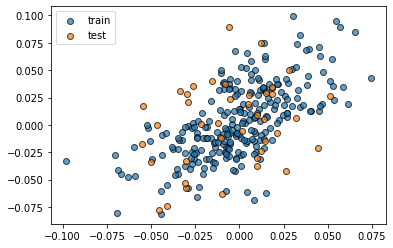

In [35]:
from sklearn.metrics import r2_score

# Evaluate the R^2 scores
print(r2_score(train_targets, train_preds))
print(r2_score(test_targets, test_preds))

# Scatter the predictions vs actual -- this one is interesting!
plt.scatter(train_preds, train_targets, label='train', edgecolor='k', alpha=0.7)
plt.scatter(test_preds, test_targets, label='test', edgecolor='k', alpha=0.7)
plt.legend(); plt.show()

Our $R^2$ values are around the average of the 3 models we ensembled. Notice the plot also looks like the bow-tie shape has been softened a bit.

## ***Join stock DataFrames and calculate returns***

Our first step towards calculating modern portfolio theory (MPT) portfolios is to get daily and monthly returns. Eventually we're going to get the best portfolios of each month based on the ***Sharpe ratio***. The easiest way to do this is to put all our stock prices into one DataFrame, then to resample them to the daily and monthly time frames. We need daily price changes to calculate volatility, which we will use as our measure of risk.

* Join together `lng_df`, `spy_df`, and `smlv_df` using **`pd.concat()`** into the `full_df` DataFrame.

* Resample the `full_df` to[ Business Month Start](http://pandas.pydata.org/pandas-docs/stable/timeseries.html#offset-aliases) (`'BMS'`) frequency.

* Get the daily percent change of `full_df` with **`.pct_change()`**.

In [36]:
lng_df, spy_df, smlv_df = pd.read_csv('lng_df.csv', index_col='Date', parse_dates=True), pd.read_csv('spy_df.csv', index_col='Date', parse_dates=True), pd.read_csv('smlv_df.csv', index_col='Date', parse_dates=True)

# Join 3 stock dataframes together
full_df = pd.concat([lng_df, spy_df, smlv_df], axis=1).dropna()

# Resample the full dataframe to monthly timeframe
monthly_df = full_df.resample('BMS').first()

# Calculate daily returns of stocks
returns_daily = full_df.pct_change()

# Calculate monthly returns of the stocks
returns_monthly = monthly_df.pct_change().dropna()
print(returns_monthly.tail())

                 LNG       SPY      SMLV
Date                                    
2018-01-01  0.128300  0.021448 -0.010725
2018-02-01  0.057770  0.047662 -0.003819
2018-03-01 -0.103353 -0.049294 -0.048135
2018-04-02  0.021396 -0.034366  0.009408
2018-05-01  0.108322  0.029168  0.027468


## ***Calculate covariances for volatility***

In MPT, we quantify risk via *volatility*. The math for calculating portfolio volatility is complex, and it requires **daily** returns covariances. We'll now loop through each month in the `returns_monthly` DataFrame, and calculate the covariance of the daily returns.

With pandas datetime indices, we can access the month and year with **`df.index.month`** and **`df.index.year`**. We'll use this to create a mask for `returns_daily` that gives us the daily returns for the current month and year in the loop. We then use the mask to subset the DataFrame like this: **`df[mask]`**. This gets entries in the `returns_daily` DataFrame which are in the current month and year in each cycle of the loop. Finally, we'll use `pandas`' **`.cov()`** method to get the covariance of daily returns.

* Loop through the index of `returns_monthly`.

* Create a mask for `returns_daily` which uses the current month and year from `returns_monthly`, and matches this to the current month and year from `i` in the loop.

* Use the mask on `returns_daily` and calculate covariances using **`.cov()`**.

In [37]:
# Daily covariance of stocks (for each monthly period)
covariances = {}
rtd_idx = returns_daily.index
for i in returns_monthly.index:    
    # Mask daily returns for each month and year, and calculate covariance
    mask = (rtd_idx.month == i.month) & (rtd_idx.year == i.year)
    
    # Use the mask to get daily returns for the current month and year of monthy returns index
    covariances[i] = returns_daily[mask].cov()

print(covariances[i])

           LNG       SPY      SMLV
LNG   0.000376  0.000057  0.000060
SPY   0.000057  0.000043  0.000023
SMLV  0.000060  0.000023  0.000025


The covariances will allow us to calculate volatility in our next step.

## ***Calculate portfolios***

We'll now generate portfolios to find each month's best one. `numpy`'s **`random.random()`** generates random numbers from a uniform distribution, then we normalize them so they sum to 1 using the `/=` operator. We use these weights to calculate returns and volatility. Returns are sums of weights times individual returns. Volatility is more complex, and involves the covariances of the different stocks.

Finally we'll store the values in dictionaries for later use, with months' dates as keys.

In this case, we will only generate 10 portfolios for each date so the code will run faster, but in a real-world use-case you'd want to use more like 1000 to 5000 randomly-generated portfolios for a few stocks.


* Generate **3** random numbers for the weights using **`np.random.random()`**.

* Calculate `returns` by taking the dot product (**`np.dot()`**; multiplies element-by-element and sums up two arrays) of `weights` with the monthly returns for the current `date` in the loop.

* Use the **`.setdefault()`** method to add an empty list (`[]`) to the `portfolio_weights` dictionary for the current date, then append `weights` to the list.

In [38]:
portfolio_returns, portfolio_volatility, portfolio_weights = {}, {}, {}

# Get portfolio performances at each month
for date in sorted(covariances.keys()):
    cov = covariances[date]
    for portfolio in range(1000):
        weights = np.random.random(3)
        weights /= np.sum(weights) # /= divides weights by their sum to normalize
        returns = np.dot(weights, returns_monthly.loc[date])
        volatility = np.sqrt(np.dot(weights.T, np.dot(cov, weights)))
        portfolio_returns.setdefault(date, []).append(returns)
        portfolio_volatility.setdefault(date, []).append(volatility)
        portfolio_weights.setdefault(date, []).append(weights)
        
print(portfolio_weights[date][0])

[0.1138721  0.47075873 0.41536917]


Now we can plot the efficient frontier.

## ***Plot efficient frontier***

We can finally plot the results of our MPT portfolios, which shows the **"efficient frontier"**. This is a plot of the <ins<volatility vs the returns</ins>. This can help us visualize our risk-return possibilities for portfolios. The ***upper left boundary of the points is the best*** we can do (highest return for a given risk), and that is the efficient frontier.

To create this plot, we will use the latest date in our `covariances` dictionary which we created a few exercises ago. This has dates as keys, so we'll get the sorted keys using **`sorted()`** and **`.keys()`**, then get the last entry with Python indexing (`[-1]`). Lastly we'll use `matplotlib` to scatter variance vs returns and see the efficient frontier for the latest date in the data.

* Get the latest date from the `covariances` dictionary -- remember the dates are the keys.

* Plot the volatility vs returns (portfolio_returns) for the latest date in a scatter plot, and set the `alpha` value for transparency to be `0.1`.

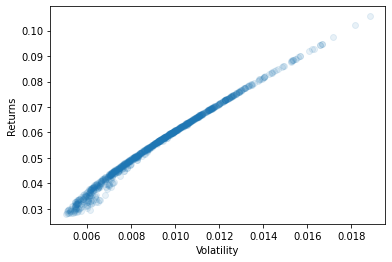

In [39]:
# Get latest date of available data
date = sorted(covariances.keys())[-1]  

# Plot efficient frontier
# warning: this can take at least 10s for the plot to execute...
plt.scatter(x=portfolio_volatility[date], y=portfolio_returns[date],  alpha=0.1)
plt.xlabel('Volatility')
plt.ylabel('Returns')
plt.show()

Often the efficient frontier will be a bullet shape, but if the returns are all positive then it may look like this.

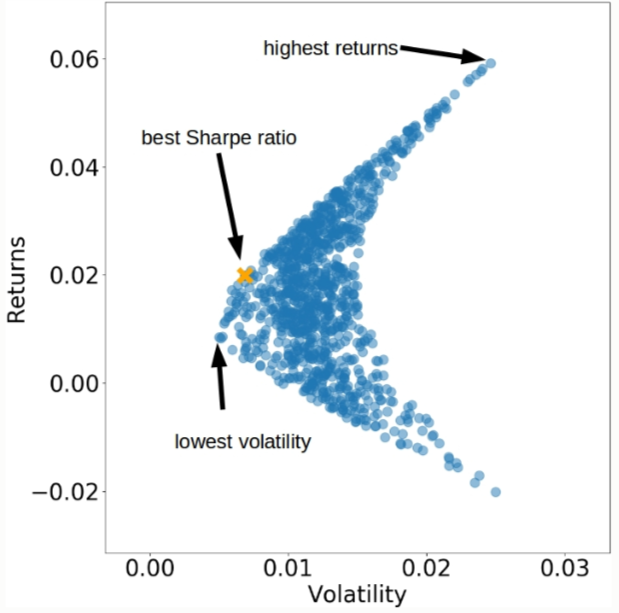

# **SHARPE RATIO**

$$\text{Sharpe Ratio} = \frac{\text{portfolio return} - \text{risk free return}}{\text{portfolio standard deviation}}$$

* Usually risk free return is assumed to be zero, which means holding cash.

## ***Get best Sharpe ratios***

We need to find the "ideal" portfolios for each date so we can use them as targets for machine learning. We'll loop through each `date` in `portfolio_returns`, then loop through the portfolios we generated with `portfolio_returns[date]`. We'll then calculate the ***Sharpe ratio***, which is the return divided by volatility (assuming a no-risk return of 0).

We use `enumerate()` to loop through the returns for the current date (`portfolio_returns[date]`) and keep track of the index with `i`. Then we use the current date and current index to get the volatility of each portfolio with `portfolio_volatility[date][i]`. Finally, we get the index of the best Sharpe ratio for each date using **`np.argmax()`**. We'll use this index to get the ideal portfolio weights soon.

* Using `enumerate()`, enumerate the `portfolio_returns` for each `date` in the loop.

* For the current `date` in the loop, append to the `sharpe_ratio` dictionary entry with the return (`ret`) divided by `portfolio_volatility` for the current date and current `i` in the loops.

* Set the value for the current date's `max_sharpe_idxs` to be the index of the maximum Sharpe ratio using **`np.argmax()`**
.

In [52]:
# Empty dictionaries for sharpe ratios and best sharpe indexes by date
sharpe_ratio, max_sharpe_idxs = {}, {}

# Loop through dates and get sharpe ratio for each portfolio
for date in portfolio_returns.keys():
    for i, ret in enumerate(portfolio_returns[date]):
    
        # Divide returns by the volatility for the date and index, i
        sharpe_ratio.setdefault(date, []).append(ret / portfolio_volatility[date][i])

    # Get the index of the best sharpe ratio for each date
    max_sharpe_idxs[date] = np.argmax(sharpe_ratio[date])

print(portfolio_returns[date][max_sharpe_idxs[date]])

0.04431822862678929


We've got our best Sharpe ratios, which we'll use to create targets for machine learning.

## ***Calculate EWMAs***

We will now work towards creating some features to be able to predict our ideal portfolios. We will simply use the price movement as a feature for now. To do this we will create a daily ***exponentially-weighted moving average*** (EWMA), then resample that to the monthly timeframe. Finally, we'll shift the monthly moving average of price one month in the future, so we can use it as a feature for predicting future portfolios.

* Use a `span` of 30 to calculate the daily exponentially-weighted moving average (`ewma_daily`).

* Resample the daily ewma to the month by using the Business Monthly Start frequency (`BMS`) and the first day of the month (**`.first()`**).

* Shift `ewma_monthly` by one month forward, so we can use the previous month's EWMA as a feature to predict the next month's ideal portfolio.

In [53]:
# Calculate exponentially-weighted moving average of daily returns
ewma_daily = returns_daily.ewm(span=30).mean()

# Resample daily returns to first business day of the month with the first day for that month
ewma_monthly = ewma_daily.resample('BMS').first()

# Shift ewma for the month by 1 month forward so we can use it as a feature for future predictions 
ewma_monthly = ewma_monthly.shift(1).dropna()

print(ewma_monthly.iloc[-1])

LNG    -0.000751
SPY    -0.002635
SMLV   -0.001181
Name: 2018-05-01 00:00:00, dtype: float64


 Now we can make our features and targets for a machine learning algorithm.

 ## ***Make features and targets***

To use machine learning to pick the best portfolio, we need to generate features and targets. Our features were just created in the last exercise – the exponentially weighted moving averages of prices. Our targets will be the best portfolios we found from the highest Sharpe ratio.

We will use `pandas`' `.iterrows()` method to get the index, value pairs for the `ewma_monthly` DataFrame. We'll set the current value of `ewma_monthly` in the loop to be our features. Then we'll use the index of the best Sharpe ratio (from `max_sharpe_idxs`) to get the best `portfolio_weights` for each month and set that as a target.


* Use the **`.iterrows()`** method with `ewma_monthly` to iterate through the `index, value` in the loop.

* Use the `date` in the loop and `best_idx` to index `portfolio_weights` to get the ideal portfolio weights based on the best Sharpe ratio.

* Append the `ewma` to the features.

In [54]:
targets, features = [], []

# Create features from price history and targets as ideal portfolio
for date, ewma in ewma_monthly.iterrows():

    # Get the index of the best sharpe ratio
    best_idx = max_sharpe_idxs[date]
    targets.append(portfolio_weights[date][best_idx])
    features.append(ewma)  # add ewma to features

targets = np.array(targets)
features = np.array(features)
print(targets[-5:])

[[8.48971181e-01 1.27753611e-01 2.32752086e-02]
 [3.93091927e-01 6.06313292e-01 5.94781004e-04]
 [2.10534870e-02 9.28484482e-01 5.04620306e-02]
 [4.43985046e-01 1.80814361e-03 5.54206811e-01]
 [2.04440858e-01 1.88500544e-01 6.07058598e-01]]


We're ready for a machine learning model.

## ***Plot efficient frontier with best Sharpe ratio***

Let's now plot the efficient frontier again, but add a marker for the portfolio with the best Sharpe index. Visualizing our data is always a good idea to better understand it.

Recall the efficient frontier is plotted in a scatter plot of portfolio volatility on the x-axis, and portfolio returns on the y-axis. We'll get the latest date we have in our data from `covariances.keys()`, although any of the `portfolio_returns`, etc, dictionaries could be used as well to get the date. Then we get volatilities and returns for the latest date we have from our `portfolio_volatility` and `portfolio_returns`. Finally we get the index of the portfolio with the best Sharpe index from `max_sharpe_idxs[date]`, and plot everything with `plt.scatter()`.

* Set `cur_volatility` to be the portfolio volatilities for the latest `date`.

* Construct the "efficient frontier" plot by plotting volatility on the x-axis and returns on the y-axis.

* Get the best portfolio index for the latest `date` from `max_sharpe_idxs`.

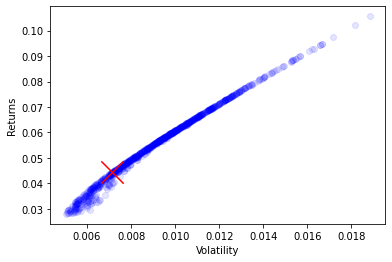

In [59]:
# Get most recent (current) returns and volatility
date = sorted(covariances.keys())[-1]
cur_returns = portfolio_returns[date]
cur_volatility = portfolio_volatility[date]

# Plot efficient frontier with sharpe as point
plt.scatter(x=cur_volatility, y=cur_returns, alpha=0.1, color='blue')
best_idx = max_sharpe_idxs[date]

# Place an orange "X" on the point with the best Sharpe ratio
plt.scatter(x=cur_volatility[best_idx], y=cur_returns[best_idx], marker='x', s=500, color='red')
plt.xlabel('Volatility')
plt.ylabel('Returns')
plt.show()

The best portfolio according to Sharpe is usually somewhere in that area where the orange x is.

## ***Make predictions with a random forest***

In order to fit a machine learning model to predict ideal portfolios, we need to create train and test sets for evaluating performance. We will do this as we did in previous chapters, where we take our features and targets arrays, and split them based on a `train_size` we set. Often the train size may be around 70-90% of our data.

We then fit our model (a random forest in this case) to the training data, and evaluate the $R^2$ scores on train and test using **`.score()`** from our model. In this case, the hyperparameters have been set for you, but usually you'd want to do a search with **`ParameterGrid`** like we did in previous chapters.

* Set the `train_size` to be 85% of the full training set data using the **`.shape`** property of features.

* Create train and test targets from targets using Python indexing.

* Fit the random forest model to the `train_features` and `train_targets`.

In [60]:
# Make train and test features
train_size = int(0.85 * features.shape[0])
train_features = features[:train_size]
test_features = features[train_size:]
train_targets = targets[:train_size]
test_targets = targets[train_size:]

# Fit the model and check scores on train and test
rfr = RandomForestRegressor(n_estimators=300, random_state=42)
rfr.fit(train_features, train_targets)
print(rfr.score(train_features, train_targets))
print(rfr.score(test_features, test_targets))

0.8263879007336574
-0.6021847289677206


The test score is not so good, but it'll work out OK in this case.

## ***Get predictions and first evaluation***

Now that we have a trained random forest model (`rfr`), we want to use it to get predictions on the test set. We do this to evaluate our model's performance – at a basic level, is it doing as well or better than just buying the index, SPY?

We'll use the typical `sklearn` **`.predict(features)`** method, then multiply our monthly returns by our portfolio predictions. We sum these up with `np.sum()` since this will have 3 rows for each month. Then we plot both the monthly returns from our predictions, as well as SPY and compare the two.

* Use the `rfr` random forest model's **`.predict()`** method to make predictions on `train_features` and `test_features`.

* Multiply the test set portion of `returns_monthly` by `test_predictions` to get the returns of our test set predictions.

* Plot the test set `returns_monthly` for 'SPY' (everything from `train_size` to the end of the data).

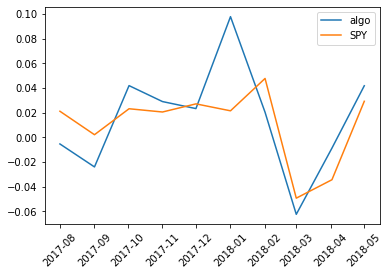

In [62]:
# Get predictions from model on train and test
train_predictions = rfr.predict(train_features)
test_predictions = rfr.predict(test_features)

# Calculate and plot returns from our RF predictions and the SPY returns
test_returns = np.sum(returns_monthly.iloc[train_size:] * test_predictions, axis=1)
plt.plot(test_returns, label='algo')
plt.plot(returns_monthly['SPY'].iloc[train_size:], label='SPY')
plt.legend()
plt.xticks(rotation=45)
plt.show()

We're doing a little better than SPY sometimes, and other times not. Let's see how it adds up...

## ***Evaluate returns***

Let's now see how our portfolio selection would perform as compared with just investing in the SPY. We'll do this to see if our predictions are promising, despite the low $R^2$ value.

We will set a starting value for our investment of $1000, then loop through the returns from our predictions as well as from SPY. We'll use the monthly returns from our portfolio selection and SPY and apply them to our starting cash balance. From this we will get a month-by-month picture of how our investment is doing, and we can see how our predictions did overall vs the SPY. Next, we can plot our portfolio from our predictions and compare it to SPY.

* Set the first list entries of both `algo_cash` and `spy_cash` to the same amount (`cash`).

* Multiply the `cash` in our `test_returns` loop by `1 + r` in order to apply the returns to our cash.

* As with the `test_returns` loop, in the SPY performance loop, append `cash` to `spy_cash` after multiplying by `1 + r` to add the returns to `cash`.

In [63]:
# Calculate the effect of our portfolio selection on a hypothetical $1k investment
cash = 1000
algo_cash, spy_cash = [cash], [cash]  # set equal starting cash amounts
for r in test_returns:
    cash *= 1 + r
    algo_cash.append(cash)

# Calculate performance for SPY
cash = 1000  # reset cash amount
for r in returns_monthly['SPY'].iloc[train_size:]:
    cash *= 1 + r
    spy_cash.append(cash)

print('algo returns:', (algo_cash[-1] - algo_cash[0]) / algo_cash[0])
print('SPY returns:', (spy_cash[-1] - spy_cash[0]) / spy_cash[0])

algo returns: 0.15466681565664225
SPY returns: 0.10942242877179752


Our predictions slightly beat the SPY!

## ***Plot returns***

Lastly, we'll plot the performance of our machine-learning-generated portfolio versus just holding the SPY. We can use this as an evaluation to see if our predictions are doing well or not.

Since we already have `algo_cash` and `spy_cash` created, all we need to do is provide them to `plt.plot()` to display. We'll also set the label for the datasets with legend in `plt.plot()`.

* Use `plt.plot()` to plot the `algo_cash` (with label `'algo'`) and `spy_cash` (with label `'SPY'`).

* Use `plt.legend()` to display the legend.

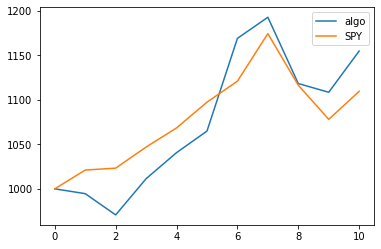

In [64]:
# Plot the algo_cash and spy_cash to compare overall returns
plt.plot(algo_cash, label='algo')
plt.plot(spy_cash, label='SPY')
plt.legend()  # show the legend
plt.show()